## This notebook walks through processing WQP data using the harmonize_WQP package


##### import the required libraries. Check requirements.txt for dependencies that should be installed.

In [1]:
import os
import geopandas
import pandas
from harmonize_wq import harmonize
from harmonize_wq import convert
from harmonize_wq import wrangle
from harmonize_wq import clean
import dataretrieval.wqp as wqp

#### Download location data using dataretrieval

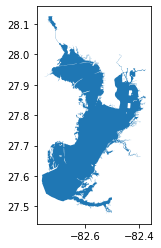

In [2]:
# Read geometry for Area of Interest from url to it in public repo
aoi_url = r'https://github.com/USEPA/Coastal_Ecological_Indicators/raw/master/DGGS_Coastal/temperature_data/TampaBay.geojson'
# Note: alternatively you can direct it to a local shapefile
aoi_gdf = geopandas.read_file(aoi_url)
# Map aoi
aoi_gdf.plot()

In [3]:
# Query for extent (rectangle) of AOI polygon
bBox = wrangle.get_bounding_box(aoi_gdf)

In [4]:
# Build query
query = {'characteristicName': ['Phosphorus',
                                'Temperature, water',
                                'Depth, Secchi disk depth',
                                'Dissolved oxygen (DO)',
                                'Salinity',
                                'pH',
                                'Nitrogen',
                                'Conductivity',
                                'Organic carbon',
                                'Chlorophyll a',
                                'Turbidity',
                                'Sediment',
                                'Fecal Coliform',
                                'Escherichia coli']}
query['bBox'] = bBox

In [5]:
# Query stations (can be slow)
stations, site_md = wqp.what_sites(**query)

In [6]:
# Rows and columns for results
stations.shape

(15167, 36)

In [7]:
# First 5 rows
stations.head()

,OrganizationIdentifier,OrganizationFormalName,MonitoringLocationIdentifier,MonitoringLocationName,MonitoringLocationTypeName,MonitoringLocationDescriptionText,HUCEightDigitCode,DrainageAreaMeasure/MeasureValue,DrainageAreaMeasure/MeasureUnitCode,ContributingDrainageAreaMeasure/MeasureValue,...,CountyCode,AquiferName,FormationTypeText,AquiferTypeName,ConstructionDateText,WellDepthMeasure/MeasureValue,WellDepthMeasure/MeasureUnitCode,WellHoleDepthMeasure/MeasureValue,WellHoleDepthMeasure/MeasureUnitCode,ProviderName
0,USGS-FL,USGS Florida Water Science Center,USGS-02300009,MANATEE RIVER AT DEVILS ELBOW NEAR FT HAMER FL,Estuary,NaN,3100202.0,139.0,sq mi,NaN,...,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1,USGS-FL,USGS Florida Water Science Center,USGS-02300018,GAMBLE CREEK NEAR PARRISH FL,Stream,NaN,3100202.0,50.6,sq mi,NaN,...,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
2,USGS-FL,USGS Florida Water Science Center,USGS-02300021,MANATEE RIVER AT FORT HAMER FL,Estuary,NaN,3100202.0,216.0,sq mi,NaN,...,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
3,USGS-FL,USGS Florida Water Science Center,USGS-02300062,GLEN CREEK NEAR BRADENTON FL,Stream,NaN,3100202.0,2.5,sq mi,NaN,...,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
4,USGS-FL,USGS Florida Water Science Center,USGS-02300064,BRADEN RIVER AT BRADENTON FL,Stream,NaN,3100202.0,83.0,sq mi,NaN,...,81,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


In [8]:
# Columns used for an example row
stations.iloc[0][['HorizontalCoordinateReferenceSystemDatumName', 'LatitudeMeasure', 'LongitudeMeasure']]

HorizontalCoordinateReferenceSystemDatumName      NAD83
LatitudeMeasure                                 27.5209
LongitudeMeasure                               -82.4018
Name: 0, dtype: object

In [9]:
# Harmonize location datums to 4326 (Note we keep intermediate columns using intermediate_columns=True)
stations_gdf = harmonize.harmonize_locations(stations, outEPSG=4326, intermediate_columns=True)

In [10]:
# Every function has a dostring to help understand input/output and what it does
harmonize.harmonize_locations?

In [11]:
# Rows and columns for results after running the function (5 new columns, only 2 new if intermediate_columns=False)
stations_gdf.shape

(15167, 41)

In [12]:
# Example results for the new columns
stations_gdf.iloc[0][['geom_orig', 'EPSG', 'QA_flag', 'geom', 'geometry']]

geom_orig         (-82.4017604, 27.5208719)
EPSG                                   4269
QA_flag                                 NaN
geom         POINT (-82.4017604 27.5208719)
geometry     POINT (-82.4017604 27.5208719)
Name: 0, dtype: object

In [13]:
# geom and geometry look the same but geometry is a special datatype
stations_gdf['geometry'].dtype

In [14]:
# Look at QA_flag for one w/ bad datum
stations_gdf.loc[stations_gdf['QA_flag'].notna()].iloc[0]['QA_flag']

'HorizontalCoordinateReferenceSystemDatumName: Bad datum UNKWN, EPSG:4326 assumed'

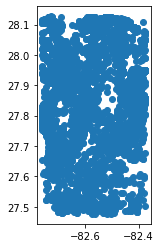

In [15]:
# Map it
stations_gdf.plot()

In [16]:
# Clip it to area of interest
aoi_gdf.to_crs(4326, inplace=True)
stations_clipped = geopandas.clip(stations_gdf, aoi_gdf)

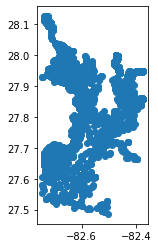

In [17]:
# Map it
stations_clipped.plot()

In [18]:
# How many stations now?
len(stations_clipped)

9972

In [19]:
# To save the results to a shapefile
#path = ''  #specify the path (folder/directory) to save it to
#stations_clipped.to_file(os.path.join(path, 'Tampa_stations.shp'))

#### Retrieve Characteristic Data

In [20]:
# Now query for results
query['dataProfile'] = 'narrowResult'
res_narrow, md_narrow = wqp.get_results(**query)

C:\ArcGIS\Local_GIS\Python\envs\arc-py3-osgeo\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (9,10,13,15,17,19,22,23,28,31,32,36,38,56,57,58,60,61,62,63,64,65,70,71,73) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [21]:
df = res_narrow
df

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,...,AnalysisEndTime/TimeZoneCode,ResultLaboratoryCommentCode,ResultLaboratoryCommentText,ResultDetectionQuantitationLimitUrl,LaboratoryAccreditationIndicator,LaboratoryAccreditationAuthorityName,TaxonomistAccreditationIndicator,TaxonomistAccreditationAuthorityName,LabSamplePreparationUrl,ProviderName
0,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,2013-11-19,14:01:00,EST,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
1,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,2013-06-12,11:01:00,EST,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,2013-07-02,11:01:00,EST,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,STORET
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,2013-07-16,11:01:00,EST,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,...,NaN,NaN,NaN,https://www.waterqualitydata.us/data/providers...,NaN,NaN,NaN,NaN,NaN,STORET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452910,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6844771,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1452911,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,1955-04-08,NaN,NaN,USGS-273926082304501,NWIS-6844774,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1452912,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,1957-10-21,14:05:00,EST,USGS-02306001,NWIS-6896640,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS
1452913,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,1955-04-08,NaN,NaN,USGS-274455082253601,NWIS-6845171,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NWIS


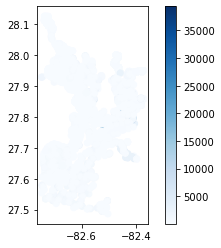

In [22]:
# Map counts of all results
results_cnt = df.groupby('MonitoringLocationIdentifier').size().to_frame('cnt')
results_cnt.reset_index(inplace=True)

# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry', 'QA_flag']
results_df = wrangle.merge_tables(results_cnt, stations_clipped, gdf_cols, merge_cols)
cnt_gdf = geopandas.GeoDataFrame(results_df, geometry='geometry')

# Map it
cnt_gdf.plot(column='cnt', cmap='Blues', legend=True)

#### Harmonize Characteristic Results

Two options for functions to harmonize characteristics: harmonize_all() or harmonize_generic(). harmonize_all runs functions on all characteristics and lets you specify how to handle errors harmonize_generic runs functions only on the characteristic specified with char_val and lets you also choose output units, to keep intermediate columns and to do a quick report summarizing changes.

In [23]:
# See Documentation
#harmonize_WQP.harmonize_all?
#harmonize_WQP.harmonize_generic?

##### secchi disk depth

L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'None' UNDEFINED UNIT
  warn("WARNING: " + problem)


-Usable results-
count    81918.000000
mean         1.477958
std          0.899999
min         -9.000000
25%          0.900000
50%          1.300000
75%          1.900000
max         32.004000
dtype: float64
Unusable results: 164
Usable results with inferred units: 0
Results outside threshold (0.0 to 6.877949780326401): 45


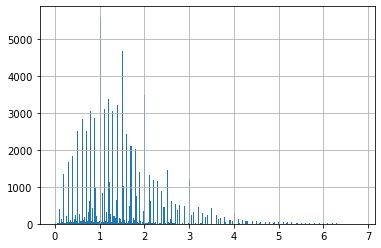

In [24]:
# Each harmonize function has optional params, e.g., char_val is the characticName column value to use so we can send the entire df.
# Optional params: units='m', char_val='Depth, Secchi disk depth', out_col='Secchi', report=False)

# We start by demonstrating on secchi disk depth (units default to m, keep intermediate fields, see report)
df = harmonize.harmonize_generic(df, 'Depth, Secchi disk depth', intermediate_columns=True, report=True)

The threshold is based on standard deviations and is currently only used in the histogram.

In [25]:
# Look at a table of just Secchi results and focus on subset of columns
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Units']
sechi_results = df.loc[df['CharacteristicName']=='Depth, Secchi disk depth', cols + ['Secchi']]
sechi_results

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
70,1.80,m,NaN,m,1.8 meter
71,1.20,m,NaN,m,1.2 meter
84,2.1,m,NaN,m,2.1 meter
85,2.1,m,NaN,m,2.1 meter
109,2.0,m,NaN,m,2.0 meter
...,...,...,...,...,...
1452594,1,m,NaN,m,1.0 meter
1452595,1.1,m,NaN,m,1.1 meter
1452596,1.5,m,NaN,m,1.5 meter
1452597,1.4,m,NaN,m,1.4 meter


In [26]:
# Look at unusable(NAN) results
sechi_results.loc[df['Secchi'].isna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
807397,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
822410,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
824037,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
833150,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
847725,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...
1427354,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1427359,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1427562,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1427802,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


In [27]:
# look at the QA flag for first row from above
list(sechi_results.loc[df['Secchi'].isna()]['QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, m assumed'

In [28]:
# All cases where there was a QA flag
sechi_results.loc[df['QA_flag'].notna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Units,Secchi
297849,-9,None,ResultMeasure/MeasureUnitCode: 'None' UNDEFINE...,m,-9.0 meter
807397,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
822410,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
824037,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
833150,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",m,NaN
...,...,...,...,...,...
1427354,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1427359,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1427562,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN
1427802,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,m,NaN


All these were missing both a value and unit so nothing could be done

In [29]:
# Aggregate Secchi data by station to look at results spatially
cols = ['MonitoringLocationIdentifier','Secchi']
secchi_df = df.loc[df['Secchi'].notna(), cols].copy()
# Col w/ magnitude seperate from unit
avg = [x.magnitude for x in secchi_df['Secchi']]
secchi_df['secchi_magnitude'] = pandas.Series(avg, index=secchi_df['Secchi'].index) 
secchi_df_agg = secchi_df.groupby('MonitoringLocationIdentifier').size().to_frame('cnt')
cols = ['MonitoringLocationIdentifier', 'secchi_magnitude']
secchi_df_agg['mean'] = secchi_df[cols].groupby('MonitoringLocationIdentifier').mean()
secchi_df_agg.reset_index(inplace=True)
secchi_df_agg

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,2,0.375000
1,21FLBRA-1541B-A,3,1.166667
2,21FLBRA-1574-A,1,0.250000
3,21FLBRA-1574A-A,2,0.250000
4,21FLBRA-1574A-B,1,1.250000
...,...,...,...
10891,USGS-280630082350900,3,1.966667
10892,USGS-280635082322100,2,2.100000
10893,USGS-280640082434700,3,2.302933
10894,USGS-280719082291400,2,1.000000


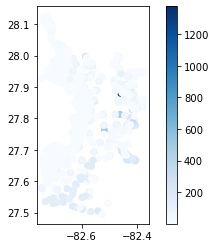

In [30]:
# Map Secchi by station
# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry']
secchi_df_agg = wrangle.merge_tables(secchi_df_agg, stations_clipped, gdf_cols, merge_cols)
secchi_gdf = geopandas.GeoDataFrame(secchi_df_agg, geometry='geometry')

# Map Counts
secchi_gdf.plot(column='cnt', cmap='Blues', legend=True)

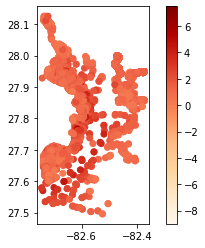

In [31]:
# Map Averages
secchi_gdf.plot(column='mean', cmap='OrRd', legend=True)

##### Temperature

The default error='raise', makes it so that there is an error when there is a dimensionality error (i.e. when units can't be converted). Here we would get the error: DimensionalityError: Cannot convert from 'count' (dimensionless) to 'degree_Celsius' ([temperature])

-Usable results-
count    288445.000000
mean         25.289683
std          81.485166
min           0.000000
25%          21.150000
50%          25.900000
75%          29.200000
max       43696.000000
dtype: float64
Unusable results: 66
Usable results with inferred units: 0
Results outside threshold (0.0 to 514.2006784264511): 1


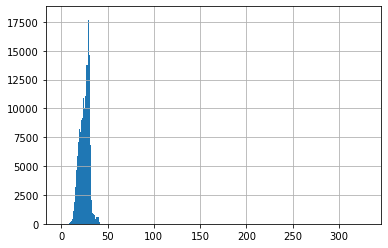

In [32]:
#'Temperature, water'
df = harmonize.harmonize_generic(df, 'Temperature, water', intermediate_columns=True, report=True)

In [33]:
# Look at what was changed
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Temperature', 'Units']
temperature_results = df.loc[df['CharacteristicName']=='Temperature, water', cols]
temperature_results

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
2,28.19,deg C,NaN,28.19 degree_Celsius,degC
12,28.88,deg C,NaN,28.88 degree_Celsius,degC
14,29.52,deg C,NaN,29.52 degree_Celsius,degC
21,25,deg C,NaN,25.0 degree_Celsius,degC
25,27.82,deg C,NaN,27.82 degree_Celsius,degC
...,...,...,...,...,...
1452899,28.9,deg C,NaN,28.9 degree_Celsius,degC
1452902,24.4,deg C,NaN,24.4 degree_Celsius,degC
1452907,25,deg C,NaN,25.0 degree_Celsius,degC
1452910,25.7,deg C,NaN,25.7 degree_Celsius,degC


In the above we can see examples where the results were in deg F and in the result field they've been converted into degree_Celsius

In [34]:
# Examine missing units
temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
811549,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
811623,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
815436,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
820463,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
822011,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...
1191588,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1336505,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1391042,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1422787,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


We can see where the units were missing, the results were assumed to be in degree_Celsius already

In [35]:
# This is also noted in the QA_flag field
list(temperature_results.loc[df['ResultMeasure/MeasureUnitCode'].isna(), 'QA_flag'])[0]

'ResultMeasureValue: "Not Reported" result cannot be used; ResultMeasure/MeasureUnitCode: MISSING UNITS, degC assumed'

In [36]:
# Look for any without usable results
temperature_results.loc[df['Temperature'].isna()]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Temperature,Units
811549,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
811623,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
815436,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
820463,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
822011,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
...,...,...,...,...,...
1191588,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1336505,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC
1391042,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN,degC
1422787,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN,degC


In [37]:
# Aggregate temperature data by station
cols = ['MonitoringLocationIdentifier','Temperature']
temp_df = df.loc[df[cols[1]].notna(), cols].copy()
# Col w/ magnitude seperate from unit
avg = [x.magnitude for x in temp_df[cols[1]]]
temp_df['Temperature_magnitude'] = pandas.Series(avg, index=temp_df[cols[1]].index) 
temp_df_agg = temp_df.groupby(cols[0]).size().to_frame('cnt')
cols += ['Temperature_magnitude']
temp_df_agg['mean'] = temp_df[cols].groupby(cols[0]).mean()
temp_df_agg.reset_index(inplace=True)
temp_df_agg

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,27.593333
1,21FLBRA-1530-B,7,26.290000
2,21FLBRA-1541A-A,6,26.016667
3,21FLBRA-1541B-A,6,26.743333
4,21FLBRA-1574-A,5,27.890000
...,...,...,...
13964,USGS-280726082313300,4,28.025000
13965,USGS-280728082301101,54,25.083333
13966,USGS-280729082313501,1,27.400000
13967,USGS-280730082313201,1,24.700000


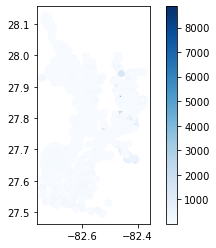

In [38]:
# Map Temperature by station
# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry']
temperature_df_agg = wrangle.merge_tables(temp_df_agg, stations_clipped, gdf_cols, merge_cols)
temp_gdf = geopandas.GeoDataFrame(temperature_df_agg, geometry='geometry')
# Map Counts
temp_gdf.plot(column='cnt', cmap='Blues', legend=True)

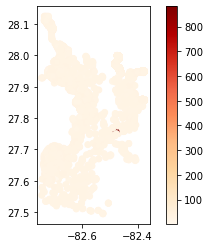

In [39]:
# Map Averages
temp_gdf.plot(column='mean', cmap='OrRd', legend=True)

###### Dissolved oxygen

In [40]:
# look at Dissolved oxygen (DO), but this time without intermediate fields
df = harmonize.harmonize_generic(df, 'Dissolved oxygen (DO)')

Note: Imediately when we run a harmonization function without the intermediate fields they're deleted.

In [41]:
# Look at what was changed
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'DO']
do_res = df.loc[df['CharacteristicName']=='Dissolved oxygen (DO)', cols]
do_res

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
1,9.32,mg/l,NaN,9.32 milligram / liter
10,4.98,mg/l,NaN,4.98 milligram / liter
11,6.07,mg/l,NaN,6.07 milligram / liter
13,4.53,mg/l,NaN,4.53 milligram / liter
15,8.08,mg/l,NaN,8.08 milligram / liter
...,...,...,...,...
1452615,4,mg/l,NaN,4.0 milligram / liter
1452616,7.2,mg/l,NaN,7.2 milligram / liter
1452617,7.4,mg/l,NaN,7.4 milligram / liter
1452618,7.9,mg/l,NaN,7.9 milligram / liter


In [42]:
do_res.loc[do_res['ResultMeasure/MeasureUnitCode']!='mg/l']

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,DO
26,86.3,%,NaN,7.130392876734 milligram / liter
112,70.7,%,NaN,5.841469019526 milligram / liter
258,41.6,%,NaN,3.437130285888 milligram / liter
286,83.6,%,NaN,6.9073099014479995 milligram / liter
311,86.7,%,NaN,7.163442206406 milligram / liter
...,...,...,...,...
1185369,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN
1187038,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN
1188579,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN
1190832,Not Reported,NaN,"ResultMeasureValue: ""Not Reported"" result cann...",NaN


Though there were no results in %, the conversion from percent saturation (%) to mg/l is special. This equation is being improved by integrating tempertaure and pressure instead of assuming STP (see DO_saturation())

In [43]:
# Aggregate DO data by station
cols = ['MonitoringLocationIdentifier','DO']
do_df = df.loc[df[cols[1]].notna(), cols].copy()
# Col w/ magnitude seperate from unit
avg = [x.magnitude for x in do_df[cols[1]]]
do_df['DO_magnitude'] = pandas.Series(avg, index=do_df[cols[1]].index) 
do_df_agg = do_df.groupby(cols[0]).size().to_frame('cnt')
cols += ['DO_magnitude']
do_df_agg['mean'] = do_df[cols].groupby(cols[0]).mean()
do_df_agg.reset_index(inplace=True)
do_df_agg

,MonitoringLocationIdentifier,cnt,mean
0,21FLBRA-1530-A,12,2.785000
1,21FLBRA-1530-B,7,4.042857
2,21FLBRA-1541A-A,6,4.721667
3,21FLBRA-1541B-A,6,6.600000
4,21FLBRA-1574-A,5,4.378000
...,...,...,...
12540,NARS_WQX-NCCA10-1672,8,5.437500
12541,NARS_WQX-NCCA10-1673,20,4.115000
12542,NARS_WQX-NCCA10-1674,6,2.466667
12543,NARS_WQX-NLA06608-0161,5,6.500000


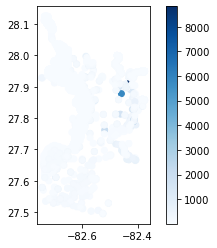

In [44]:
# Map DO by station
# Join it to geometry
merge_cols = ['MonitoringLocationIdentifier']
gdf_cols = ['geometry']
do_df_agg = wrangle.merge_tables(do_df_agg, stations_clipped, gdf_cols, merge_cols)
do_gdf = geopandas.GeoDataFrame(do_df_agg, geometry='geometry')
# Map Counts
do_gdf.plot(column='cnt', cmap='Blues', legend=True)

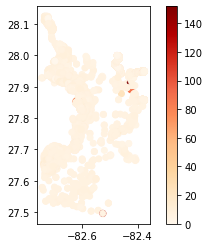

In [45]:
# Map Averages
do_gdf.plot(column='mean', cmap='OrRd', legend=True)

###### pH

-Usable results-
count    264854.000000
mean          7.767824
std           0.470427
min           0.370000
25%           7.540000
50%           7.900000
75%           8.070000
max          12.970000
dtype: float64
Unusable results: 75
Usable results with inferred units: 0
Results outside threshold (0.0 to 10.590388978557112): 7


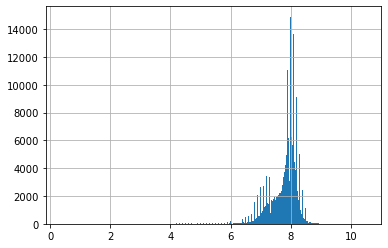

In [46]:
# pH, this time looking at a report
df = harmonize.harmonize_generic(df, 'pH', report=True)

Note the warnings that occur when a unit is not recognized by the package. These occur even when report=False. Future versions could include these as defined units for pH, but here it wouldn't alter results.

In [47]:
df.loc[df['CharacteristicName']=='pH', ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'pH']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,pH
5,7.48,None,NaN,7.48 dimensionless
6,8.18,None,NaN,8.18 dimensionless
8,7.81,None,NaN,7.81 dimensionless
16,7.96,None,NaN,7.96 dimensionless
27,8.19,None,NaN,8.19 dimensionless
...,...,...,...,...
1452908,7.9,std units,NaN,7.9 dimensionless
1452909,7.3,std units,NaN,7.3 dimensionless
1452911,7.8,std units,NaN,7.8 dimensionless
1452912,7.7,std units,NaN,7.7 dimensionless


'None' is uninterpretable and replaced with NaN, which then gets replaced with 'dimensionless' since pH is unitless

###### Salinity

-Usable results-
count    255587.000000
mean         22.014947
std          97.448017
min          -0.020000
25%          18.625000
50%          25.000000
75%          28.800000
max       48930.000000
dtype: float64
Unusable results: 1186
Usable results with inferred units: 0
Results outside threshold (0.0 to 606.7030474368141): 4


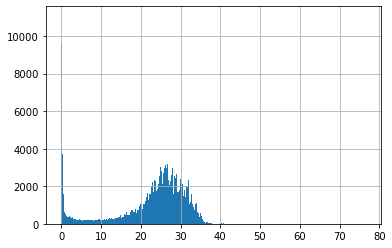

In [48]:
# Salinity
df = harmonize.harmonize_generic(df, 'Salinity', report=True, errors='ignore')

In [49]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
df.loc[df['CharacteristicName']=='Salinity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
0,40,ppth,NaN,40.0 Practical_Salinity_Units
7,29,PSS,NaN,29.0 Practical_Salinity_Units
9,26.04,PSS,NaN,26.04 Practical_Salinity_Units
17,22.03,PSS,NaN,22.03 Practical_Salinity_Units
19,10.90,ppth,NaN,10.9 Practical_Salinity_Units
...,...,...,...,...
1452600,21.3,PSS,NaN,21.3 Practical_Salinity_Units
1452602,20.97,PSS,NaN,20.97 Practical_Salinity_Units
1452605,19.9,PSS,NaN,19.9 Practical_Salinity_Units
1452611,20.4,PSS,NaN,20.4 Practical_Salinity_Units


###### Nitrogen

-Usable results-
count    171.000000
mean       1.519947
std        4.431668
min        0.024000
25%        0.206500
50%        0.321000
75%        0.498000
max       22.500000
dtype: float64
Unusable results: 2
Usable results with inferred units: 0
Results outside threshold (0.0 to 28.109954933438868): 0


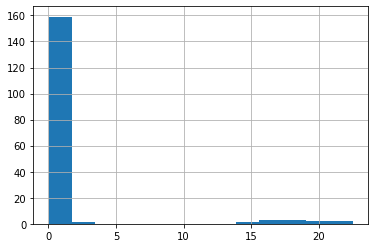

In [50]:
# Nitrogen
df = harmonize.harmonize_generic(df, 'Nitrogen', report=True)

In [51]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Nitrogen']
df.loc[df['CharacteristicName']=='Nitrogen', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Nitrogen
245583,0.425,mg/l,NaN,0.425 milligram / liter
245584,0.425,mg/l,NaN,0.425 milligram / liter
255634,0.4625,mg/l,NaN,0.4625 milligram / liter
255635,0.4625,mg/l,NaN,0.4625 milligram / liter
255652,0.33625,mg/l,NaN,0.33625 milligram / liter
...,...,...,...,...
1448022,0.084,mg/l,NaN,0.084 milligram / liter
1448030,0.166,mg/l,NaN,0.166 milligram / liter
1448040,0.091,mg/l,NaN,0.091 milligram / liter
1448074,0.057,mg/l,NaN,0.057 milligram / liter


###### Conductivity

-Usable results-
count     12.000000
mean     687.416667
std       80.977503
min      606.000000
25%      606.000000
50%      660.500000
75%      775.250000
max      776.000000
dtype: float64
Unusable results: 92
Usable results with inferred units: 0
Results outside threshold (0.0 to 1173.2816872040771): 0


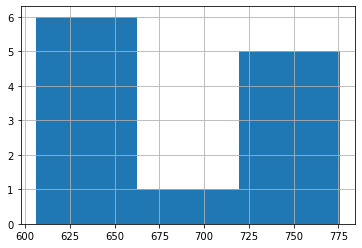

In [52]:
df = harmonize.harmonize_generic(df, 'Conductivity', report=True)

Note: No report because too few results

In [53]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Conductivity']
df.loc[df['CharacteristicName']=='Conductivity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Conductivity
367970,775,uS/cm,NaN,775.0 microsiemens / centimeter
371540,776,uS/cm,NaN,776.0 microsiemens / centimeter
381837,776,uS/cm,NaN,776.0 microsiemens / centimeter
385680,776,uS/cm,NaN,776.0 microsiemens / centimeter
388148,775,uS/cm,NaN,775.0 microsiemens / centimeter
...,...,...,...,...
659621,633,uS/cm,NaN,633.0 microsiemens / centimeter
668524,688,uS/cm,NaN,688.0 microsiemens / centimeter
669584,626,uS/cm,NaN,626.0 microsiemens / centimeter
671215,606,uS/cm,NaN,606.0 microsiemens / centimeter


###### Chlorophyll a

-Usable results-
count    43861.000000
mean         0.014295
std          0.022687
min         -0.003000
25%          0.004510
50%          0.008670
75%          0.016290
max          1.552000
dtype: float64
Unusable results: 1115
Usable results with inferred units: 4
Results outside threshold (0.0 to 0.1504161349185894): 207


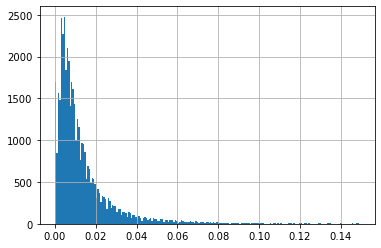

In [54]:
# Chlorophyll a
df = harmonize.harmonize_generic(df, 'Chlorophyll a', report=True)

In [55]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Chlorophyll']
df.loc[df['CharacteristicName']=='Chlorophyll a', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Chlorophyll
241396,1.45,ug/l,NaN,0.00145 milligram / liter
241405,2.77,ug/l,NaN,0.00277 milligram / liter
257457,2.68,ug/l,NaN,0.00268 milligram / liter
258323,7.69,ug/l,NaN,0.007690000000000001 milligram / liter
285437,4.42,ug/l,NaN,0.00442 milligram / liter
...,...,...,...,...
1452592,18.16,ug/l,NaN,0.01816 milligram / liter
1452593,41.09,ug/l,NaN,0.04109 milligram / liter
1452604,23.55,ug/l,NaN,0.02355 milligram / liter
1452606,37.07,ug/l,NaN,0.03707 milligram / liter


###### Organic Carbon

-Usable results-
count    2.951500e+04
mean     1.845955e+04
std      1.628788e+06
min      0.000000e+00
25%      4.600000e+00
50%      7.160000e+00
75%      1.200000e+01
max      2.000000e+08
dtype: float64
Unusable results: 1988
Usable results with inferred units: 0
Results outside threshold (0.0 to 9791188.219878854): 9


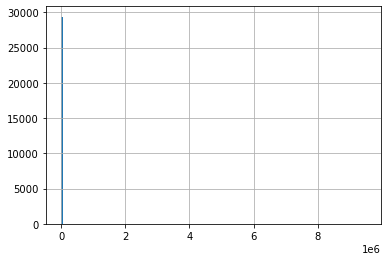

In [56]:
# Organic carbon (%)
df = harmonize.harmonize_generic(df, 'Organic carbon', report=True)

In [57]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Carbon']
df.loc[df['CharacteristicName']=='Organic carbon', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Carbon
3,3.8,mg/l,NaN,3.8 milligram / liter
4,3.8,mg/l,NaN,3.8 milligram / liter
57,3.0,mg/l,NaN,3.0 milligram / liter
58,3.0,mg/l,NaN,3.0 milligram / liter
78,8.7,mg/l,NaN,8.7 milligram / liter
...,...,...,...,...
1451336,13.8,mg/l,NaN,13.8 milligram / liter
1451381,9.8,mg/l,NaN,9.8 milligram / liter
1451392,13.7,mg/l,NaN,13.7 milligram / liter
1451419,16.4,mg/l,NaN,16.4 milligram / liter


###### Turbidity

-Usable results-
count    112202.000000
mean         13.867305
std         790.988668
min          -0.047700
25%           1.500000
50%           2.500000
75%           4.100000
max      200000.000000
dtype: float64
Unusable results: 1487
Usable results with inferred units: 0
Results outside threshold (0.0 to 4759.799311214631): 158


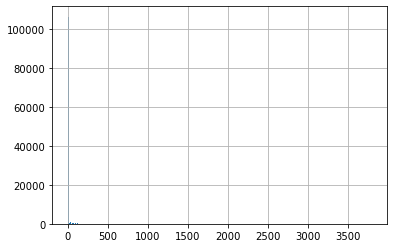

In [58]:
# Turbidity (NTU)
df = harmonize.harmonize_generic(df, 'Turbidity', report=True, errors='ignore')

In [59]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Turbidity']
df.loc[df['CharacteristicName']=='Turbidity', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Turbidity
22,0.9,NTU,NaN,0.9 Nephelometric_Turbidity_Units
23,0.9,NTU,NaN,0.9 Nephelometric_Turbidity_Units
90,2.4,NTU,NaN,2.4 Nephelometric_Turbidity_Units
137,5.6,NTU,NaN,5.6 Nephelometric_Turbidity_Units
138,5.6,NTU,NaN,5.6 Nephelometric_Turbidity_Units
...,...,...,...,...
1451368,2.3,NTU,NaN,2.3 Nephelometric_Turbidity_Units
1451369,3.5,NTU,NaN,3.5 Nephelometric_Turbidity_Units
1451386,1.7,NTU,NaN,1.7 Nephelometric_Turbidity_Units
1451395,2.5,NTU,NaN,2.5 Nephelometric_Turbidity_Units


###### Sediment

In [60]:
# Sediment
df = harmonize.harmonize_generic(df, 'Sediment', report=False)

In [61]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Sediment']
df.loc[df['CharacteristicName']=='Sediment', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Sediment
1419759,28,%,NaN,280.0 gram / kilogram
1419760,38,%,NaN,380.0 gram / kilogram
1426685,97,%,NaN,970.0 gram / kilogram
1426686,99,%,NaN,990.0 gram / kilogram
1426687,100,%,NaN,1000.0 gram / kilogram
1426688,100,%,NaN,1000.0 gram / kilogram
1426689,100,%,NaN,1000.0 gram / kilogram
1426690,100,%,NaN,1000.0 gram / kilogram
1443920,NaN,NaN,ResultMeasureValue: missing (NaN) result; Resu...,NaN


###### Phosphorus

Note: must be merged w/ activities (package runs query by site if not already merged)

In [62]:
# Phosphorus
# Note: must be merged w/ activities (package runs query by site if not already merged)
df = harmonize.harmonize_generic(df, 'Phosphorus')

L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:157: UserWarning: WARNING: 'percent' UNDEFINED UNIT
  warn("WARNING: " + problem)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Non-filterable_Phosphorus" column for Non-filterable, may be error
  warn('Warning: ' + prob)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Filterable_Phosphorus" column for Filterable, may be error
  warn('Warning: ' + prob)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Total_Recoverable_Phosphorus" column for Total Recoverable, may be error
  warn('Warning: ' + prob)
L:\Public\jbousqui\Code\GitHub\HWBI_update\ESI\harmonize-wq\harmonize_wq\harmonize.py:435: UserWarning: Warning: "Bed_Sediment_Phosphorus" column for Bed Sediment, may be error
  warn('Warning: ' + prob)
L:\Pub

Note the warnings for unexpected characteristic fractions. Fractions are each seperated out into their own result column.

In [63]:
# Total dissolved phosphorus
df.loc[df['TDP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TDP_Phosphorus']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TDP_Phosphorus
10826,0.003,mg/l,NaN,0.003 milligram / liter
23497,0.050,mg/l,NaN,0.05 milligram / liter
35178,0.009,mg/l,NaN,0.009000000000000001 milligram / liter
190320,0.011,mg/l,NaN,0.011000000000000001 milligram / liter
216271,0.002,mg/l,NaN,0.002 milligram / liter
...,...,...,...,...
1438203,0.08,mg/l as P,NaN,0.08 milligram / liter
1438229,0.06,mg/l as P,NaN,0.06 milligram / liter
1438312,0.1,mg/l as P,NaN,0.1 milligram / liter
1438327,0.04,mg/l as P,NaN,0.04 milligram / liter


In [64]:
# Total phosphorus
df.loc[df['TP_Phosphorus'].notna(), ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'TP_Phosphorus']]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,TP_Phosphorus
1000,0.049,mg/l,NaN,0.049 milligram / liter
7859,0.036,mg/l,NaN,0.036000000000000004 milligram / liter
8833,0.053,mg/l,NaN,0.053 milligram / liter
12292,0.002,mg/l,NaN,0.002 milligram / liter
13175,0.039,mg/l,NaN,0.039 milligram / liter
...,...,...,...,...
1451308,0.134,mg/l,NaN,0.134 milligram / liter
1451320,0.156,mg/l,NaN,0.156 milligram / liter
1451330,0.208,mg/l,NaN,0.20800000000000002 milligram / liter
1451344,0.116,mg/l,NaN,0.11599999999999999 milligram / liter


##### Bacteria

Some equivalence assumptions are built-in where bacteria counts that are not equivalent are treated as such because there is no standard way to convert from one to another.

###### Fecal Coliform

-Usable results-
count    5.235500e+04
mean     1.158049e+03
std      5.362204e+04
min      0.000000e+00
25%      6.000000e+00
50%      3.300000e+01
75%      2.550000e+02
max      1.000000e+07
dtype: float64
Unusable results: 31044
Usable results with inferred units: 5
Results outside threshold (0.0 to 322890.3186714686): 18


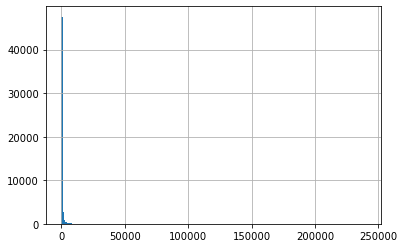

In [65]:
df = harmonize.harmonize_generic(df, 'Fecal Coliform', report=True)

In [66]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Fecal_Coliform']
df.loc[df['CharacteristicName']=='Fecal Coliform', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Fecal_Coliform
44,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
45,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
46,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
47,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
55,*Non-detect,NaN,"ResultMeasureValue: ""*Non-detect"" result canno...",NaN
...,...,...,...,...
1451387,2600,cfu/100ml,NaN,2600.0 Colony_Forming_Units / milliliter
1451399,2,cfu/100ml,NaN,2.0 Colony_Forming_Units / milliliter
1451407,1,cfu/100ml,NaN,1.0 Colony_Forming_Units / milliliter
1451422,1,cfu/100ml,NaN,1.0 Colony_Forming_Units / milliliter


###### Escherichia coli

-Usable results-
count     4206.000000
mean       727.244650
std       1892.398394
min          0.000000
25%         75.000000
50%        250.000000
75%        650.000000
max      41000.000000
dtype: float64
Unusable results: 393
Usable results with inferred units: 0
Results outside threshold (0.0 to 12081.635013167983): 22


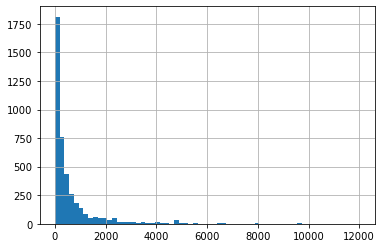

In [67]:
df = harmonize.harmonize_generic(df, 'Escherichia coli', report=True)

In [68]:
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'E_coli']
df.loc[df['CharacteristicName']=='Escherichia coli', cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,E_coli
393705,28,MPN/100ml,NaN,28.0 Colony_Forming_Units / milliliter
394444,250,MPN/100ml,NaN,250.0 Colony_Forming_Units / milliliter
394532,580,MPN/100ml,NaN,580.0 Colony_Forming_Units / milliliter
394845,93,MPN/100ml,NaN,93.0 Colony_Forming_Units / milliliter
401057,1000,MPN/100ml,NaN,1000.0 Colony_Forming_Units / milliliter
...,...,...,...,...
1451057,2700,cfu/100ml,NaN,2700.0 Colony_Forming_Units / milliliter
1451069,92,cfu/100ml,NaN,92.0 Colony_Forming_Units / milliliter
1451079,280,cfu/100ml,NaN,280.0 Colony_Forming_Units / milliliter
1451083,120,cfu/100ml,NaN,120.0 Colony_Forming_Units / milliliter


### Combining Salinity and Conductivity

Convert module has various functions to convert from one unit or characteristic to another. Some of these are used within a single characteristic during harmonization (e.g. DO saturation to concentration) while others are intended to model one characteristic as an indicator of another (e.g. estimate salinity from conductivity).

Note: this should only be done after both characteristic fields have been harmonized. Results before and after should be inspected, thresholds for outliers applied, and consider adding a QA_flag for modeled data.

There are not enough conductivity results to demonstrate this fully in pensacola Bay. We'll mainly just explore Salinity results.

In [69]:
#Notes:
#df[df['Conductivity'].notna(), 'Salinity'] = df[df['Conductivity'].notna()].apply(harmonize_WQP.conductivity_to_PSU)
#df['Conductivity'].dropna().equals(df[df['Conductivity'].notna()]['Conductivity'])

In [70]:
# First note initial Salinity info
lst = [x.magnitude for x in list(df['Salinity'].dropna())]
q_sum = sum(lst)
print('Range: {} to {}'.format(min(lst), max(lst)))
print('Results: {} \nMean: {} PSU'.format(len(lst), q_sum/len(lst)))

Range: -0.02 to 48930.0
Results: 255587 
Mean: 22.014947283703794 PSU


In [71]:
# Identify extreme outliers
[x for x in lst if x >3200]

[48930.0]

In [72]:
# Look at important fields for max value
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity']
salinity_series = df['Salinity'][df['Salinity'].notna()]
x = max(salinity_series)
idx = df[df['Salinity']==x].index
df[cols][df['Salinity']==x]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
564842,48930,ppth,NaN,48930.0 Practical_Salinity_Units


In [73]:
# Look at important fields for second max value
x2 = max(salinity_series.drop(index=idx))
df[cols][df['Salinity']==x2]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity
758385,2976,ppth,NaN,2976.0 Practical_Salinity_Units


Nothing jumps out as problematic for either value

In [74]:
# Create series and inspect Conductivity values
cond_series = df['Conductivity'].dropna()
cond_series

367970    775.0 microsiemens / centimeter
371540    776.0 microsiemens / centimeter
381837    776.0 microsiemens / centimeter
385680    776.0 microsiemens / centimeter
388148    775.0 microsiemens / centimeter
650426    606.0 microsiemens / centimeter
650427    606.0 microsiemens / centimeter
659621    633.0 microsiemens / centimeter
668524    688.0 microsiemens / centimeter
669584    626.0 microsiemens / centimeter
671215    606.0 microsiemens / centimeter
671216    606.0 microsiemens / centimeter
Name: Conductivity, dtype: object

Conductivity thresholds from Freshwater Explorer: 10 > x < 5000 us/cm. The value we have is well within that.

In [75]:
# Check other relevant columns before converting (e.g. Salinity)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'QA_flag', 'Salinity', 'Conductivity']
df.loc[df['Conductivity'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,QA_flag,Salinity,Conductivity
367970,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
371540,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
381837,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
385680,776,uS/cm,NaN,NaN,776.0 microsiemens / centimeter
388148,775,uS/cm,NaN,NaN,775.0 microsiemens / centimeter
650426,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter
650427,606,uS/cm,NaN,NaN,606.0 microsiemens / centimeter
659621,633,uS/cm,NaN,NaN,633.0 microsiemens / centimeter
668524,688,uS/cm,NaN,NaN,688.0 microsiemens / centimeter
669584,626,uS/cm,NaN,NaN,626.0 microsiemens / centimeter


In [76]:
idx = df.loc[df['Conductivity'].notna(), cols].index[0]
cond_series[idx]

775.0 <Unit('microsiemens / centimeter')>

In [77]:
cond_series.apply(str)

367970    775.0 microsiemens / centimeter
371540    776.0 microsiemens / centimeter
381837    776.0 microsiemens / centimeter
385680    776.0 microsiemens / centimeter
388148    775.0 microsiemens / centimeter
650426    606.0 microsiemens / centimeter
650427    606.0 microsiemens / centimeter
659621    633.0 microsiemens / centimeter
668524    688.0 microsiemens / centimeter
669584    626.0 microsiemens / centimeter
671215    606.0 microsiemens / centimeter
671216    606.0 microsiemens / centimeter
Name: Conductivity, dtype: object

In [78]:
# Convert values to PSU and write to Salinity
cond_series = cond_series.apply(str)  # Convert to string to convert to dimensionless (PSU)
df.loc[df['Conductivity'].notna(), 'Salinity'] = cond_series.apply(convert.conductivity_to_PSU)
df.loc[df['Conductivity'].notna(), 'Salinity']

367970    0.379 dimensionless
371540    0.379 dimensionless
381837    0.379 dimensionless
385680    0.379 dimensionless
388148    0.379 dimensionless
650426    0.294 dimensionless
650427    0.294 dimensionless
659621    0.308 dimensionless
668524    0.335 dimensionless
669584    0.304 dimensionless
671215    0.294 dimensionless
671216    0.294 dimensionless
Name: Salinity, dtype: object

In [79]:
print('{} PSU is close to expected from {}?'.format(df.loc[df['Conductivity'].notna(), 'Salinity'][idx],cond_series[idx]))

0.379 dimensionless PSU is close to expected from 775.0 microsiemens / centimeter?


In [80]:
# Combining Secchi and Turbidity

### QA Standards

In [81]:
# QA standards
#what_detection_limits(**kwargs):

### Datetime

datetime() formats time using dataretrieval and ActivityStart

In [82]:
# First inspect the existing unformated fields
cols = ['ActivityStartDate', 'ActivityStartTime/Time', 'ActivityStartTime/TimeZoneCode']
df[cols]

,ActivityStartDate,ActivityStartTime/Time,ActivityStartTime/TimeZoneCode
0,2013-11-19,14:01:00,EST
1,2013-06-12,11:01:00,EST
2,2013-07-02,11:01:00,EST
3,2013-07-16,11:01:00,EST
4,2013-07-16,11:01:00,EST
...,...,...,...
1452910,1955-04-08,NaN,NaN
1452911,1955-04-08,NaN,NaN
1452912,1957-10-21,14:05:00,EST
1452913,1955-04-08,NaN,NaN


In [83]:
# Note the input columns are dropped (rename the result to preserve these columns)
df = clean.datetime(df)
df[['StartDate', 'Activity_datetime']]

,StartDate,Activity_datetime
0,2013-11-19,2013-11-19 19:01:00+00:00
1,2013-06-12,2013-06-12 16:01:00+00:00
2,2013-07-02,2013-07-02 16:01:00+00:00
3,2013-07-16,2013-07-16 16:01:00+00:00
4,2013-07-16,2013-07-16 16:01:00+00:00
...,...,...
1452910,1955-04-08,NaT
1452911,1955-04-08,NaT
1452912,1957-10-21,1957-10-21 19:05:00+00:00
1452913,1955-04-08,NaT


Activity_datetime combines all three time component columns into UTC. If time is missing this is NaT so a startDate column is used to preserve date only.

### Characteristic to Column (long to wide format)

In [84]:
# Split single QA column into multiple by characteristic (rename the result to preserve these QA_flags)
df2 = wrangle.split_col(df)
df2

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,DataLoggerLine,ResultDetectionConditionText,MethodSpecificationName,CharacteristicName,ResultSampleFractionText,...,QA_E_coli,QA_Nitrogen,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Bed_Sediment_Phosphorus,QA_Unfiltered_Phosphorus,QA_Sediment,QA_Temperature,QA_DO
0,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,21FLSEAS_WQX-48SEAS190,STORET-310535134,NaN,NaN,NaN,Salinity,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,21FLHILL_WQX-585,STORET-301235413,NaN,NaN,NaN,Dissolved oxygen (DO),Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,21FLHILL_WQX-047,STORET-300620295,NaN,NaN,NaN,"Temperature, water",Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,NaN,Organic carbon,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,21FLHILL_WQX-021,STORET-300666279,NaN,NaN,NaN,Organic carbon,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1452910,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,USGS-273926082304501,NWIS-6844771,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1452911,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500762,USGS-273926082304501,NWIS-6844774,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1452912,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95800924,USGS-02306001,NWIS-6896640,NaN,NaN,NaN,pH,Total,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1452913,USGS-FL,USGS Florida Water Science Center,nwisfl.01.95500782,USGS-274455082253601,NWIS-6845171,NaN,NaN,NaN,"Temperature, water",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
# This expands the single col (QA_flag) out to a number of new columns based on the unique characteristicNames and speciation
print('{} new columns'.format(len(df2.columns) - len(df.columns)))

17 new columns


In [86]:
# Note: there are fewer rows because NAN results are also dropped in this step
print('{} fewer rows'.format(len(df)-len(df2)))

38471 fewer rows


In [87]:
#Examine Carbon flags from earlier in notebook (note these are empty now because NAN is dropped)
cols = ['ResultMeasureValue', 'ResultMeasure/MeasureUnitCode', 'Carbon', 'QA_Carbon']
df2.loc[df2['QA_Carbon'].notna(), cols]

,ResultMeasureValue,ResultMeasure/MeasureUnitCode,Carbon,QA_Carbon


Next the table is divided into the columns of interest (main_df) and characteristic specific metadata (chars_df)

In [88]:
# split table into main and characteristics tables
main_df, chars_df = wrangle.split_table(df2)

In [89]:
# Columns still in main table
main_df.columns

Index(['OrganizationIdentifier', 'OrganizationFormalName',
       'ActivityIdentifier', 'MonitoringLocationIdentifier',
       'ResultIdentifier', 'ProviderName', 'Secchi', 'Temperature', 'DO', 'pH',
       'Salinity', 'Nitrogen', 'Speciation', 'Conductivity', 'Chlorophyll',
       'Carbon', 'Turbidity', 'Sediment', 'Phosphorus', 'TP_Phosphorus',
       'TDP_Phosphorus', 'Other_Phosphorus', 'Bed_Sediment_Phosphorus',
       'Unfiltered_Phosphorus', 'Fecal_Coliform', 'E_coli', 'StartDate',
       'Activity_datetime', 'QA_Turbidity', 'QA_Chlorophyll',
       'QA_Fecal_Coliform', 'QA_Secchi', 'QA_Salinity', 'QA_Conductivity',
       'QA_pH', 'QA_Carbon', 'QA_E_coli', 'QA_Nitrogen', 'QA_TP_Phosphorus',
       'QA_TDP_Phosphorus', 'QA_Other_Phosphorus',
       'QA_Bed_Sediment_Phosphorus', 'QA_Unfiltered_Phosphorus', 'QA_Sediment',
       'QA_Temperature', 'QA_DO', 'Depth'],
      dtype='object')

In [90]:
# look at main table results (first 5)
main_df.head()

,OrganizationIdentifier,OrganizationFormalName,ActivityIdentifier,MonitoringLocationIdentifier,ResultIdentifier,ProviderName,Secchi,Temperature,DO,pH,...,QA_Nitrogen,QA_TP_Phosphorus,QA_TDP_Phosphorus,QA_Other_Phosphorus,QA_Bed_Sediment_Phosphorus,QA_Unfiltered_Phosphorus,QA_Sediment,QA_Temperature,QA_DO,Depth
0,21FLSEAS_WQX,Florida Department of Environmental Protection,21FLSEAS_WQX-481901119134,21FLSEAS_WQX-48SEAS190,STORET-310535134,STORET,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130612585-W,21FLHILL_WQX-585,STORET-301235413,STORET,NaN,NaN,9.32 milligram / liter,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130702047-M,21FLHILL_WQX-047,STORET-300620295,STORET,NaN,28.19 degree_Celsius,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,21FLHILL_WQX-021,STORET-300666279,STORET,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21FLHILL_WQX,Environmental Protection Commission of Hillsbo...,21FLHILL_WQX-130716021,21FLHILL_WQX-021,STORET-300666279,STORET,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Empty columns that could be dropped (Mostly QA columns)
cols = list(main_df.columns)
x = main_df.dropna(axis=1, how='all')
[col for col in cols if col not in x.columns]

['QA_Turbidity',
 'QA_Salinity',
 'QA_Conductivity',
 'QA_pH',
 'QA_Carbon',
 'QA_E_coli',
 'QA_Nitrogen',
 'QA_TDP_Phosphorus',
 'QA_Other_Phosphorus',
 'QA_Unfiltered_Phosphorus',
 'QA_Sediment',
 'QA_Temperature',
 'QA_DO']

In [92]:
# Join to stations to quickly aggegate/map
merge_cols = ['MonitoringLocationIdentifier', 'OrganizationIdentifier']
gdf_cols = ['geometry', 'QA_flag']
results_df = wrangle.merge_tables(main_df, stations_clipped, gdf_cols, merge_cols)

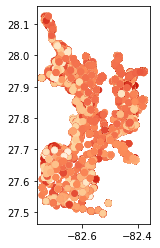

In [93]:
# Map average temperature
results_gdf = geopandas.GeoDataFrame(results_df, geometry='geometry')
results_gdf.plot(column='Temperature', cmap='OrRd')